In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import quimb as qu
import quimb.tensor as qtn
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
)

/home/ampolloreno/repos/cotengra/cotengra/hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [3]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
import numpy as np
from qiskit import Aer, execute
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
import networkx as nx

np.random.seed(666)
reprate = 25 
one_hour = 60 * 60 #seconds
max_gamma = 2 * np.pi
max_beta = np.pi

n = 20
m = int(3*n/5)
edges = []
while len(edges) < m:
    edge = (np.random.randint(n), np.random.randint(n))
    if edge not in edges and (edge[1], edge[0]) not in edges and edge[0] != edge[1]:
        
        edges.append(edge)
weights = {edge:((np.random.rand(1)-.5)*2)[0] for edge in edges}
positive_edges = [edge for edge in edges if weights[edge]>0]
#weights = {edge:1 for edge in edges}
graph=nx.Graph()
graph.add_weighted_edges_from([(edge[0], edge[1], weights[edge]) for edge in edges])


terms = weights
circ_ex = None
BASELINE_SHOTS = 100

def objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
#         ens = [
#             circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
#             for edge, weight in terms.items()
#         ]
            
#         return sum(ens).real
        samples = list(circ_ex.simulate_counts(shots_per_point))
        values = []
        for sample in samples:
            value = 0
            for k, v in terms.items():
                if sample[k[0]] != sample[k[1]]:
                    value += v
            values.append(value)
        return np.mean(values)
    return gamma_beta_objective, history

def expectation_objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
        ens = [
            circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
            for edge, weight in terms.items()
        ]
            
        return -sum(ens).real
    return gamma_beta_objective, history



/home/ampolloreno/anaconda3/envs/qaoa/lib/python3.8/site-packages/qiskit/validation/fields/custom.py:76: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.integer, numpy.float,
/home/ampolloreno/anaconda3/envs/qaoa/lib/python3.8/site-packages/qiskit/quantum_info/operators/pauli.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.zer

<ipython-input-4-3a2e1d7ccf7f>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #


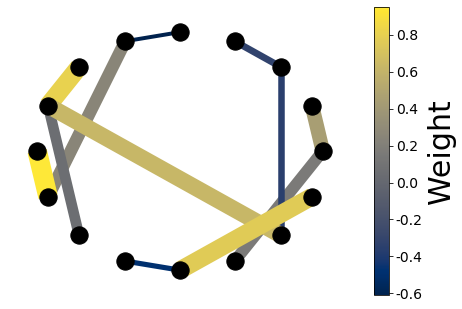

In [4]:
import matplotlib.pyplot as plt
pos=nx.circular_layout(graph)
colors=[int(100+100*weights.get(edge, weights.get((edge[1], edge[0])))) for edge in graph.edges]
widths = [10+10*weights.get(edge, weights.get((edge[1], edge[0]))) for edge in graph.edges]
cmap=plt.cm.cividis
vmin = min(colors)
vmax = max(colors)
nx.draw(graph, pos, node_color='k', edge_color=colors, width=widths, edge_cmap=cmap,
           with_labels=False, vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb= plt.colorbar(sm)
cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #
cb.set_label('Weight', fontsize=30)
#plt.show()
tick_font_size = 14
cb.ax.tick_params(labelsize=tick_font_size)
plt.savefig("/home/ampolloreno/graph.png", dpi=200, bbox_inches='tight')


In [5]:
import networkx as nx
obj, hist = expectation_objective(graph)
all_data = []
bound = np.pi
samples = 20
for g in list(reversed(np.linspace(0, bound, num=samples))):
    data = []
    print(g)
    for b in np.linspace(0, bound, num=samples):
        data.append(obj([b, g]))
    all_data.append(data)

3.141592653589793
2.9762456718219092
2.8108986900540254
2.6455517082861415
2.4802047265182576
2.3148577447503738
2.14951076298249
1.984163781214606
1.8188167994467224
1.6534698176788385
1.4881228359109546
1.3227758541430708
1.1574288723751869
0.992081890607303
0.8267349088394192
0.6613879270715354
0.4960409453036515
0.3306939635357677
0.16534698176788384
0.0


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])


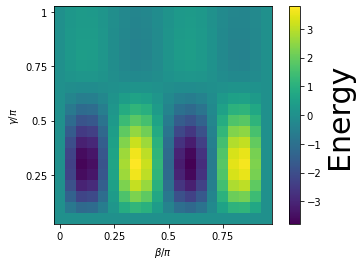

In [6]:
import matplotlib.pyplot as plt
plt.imshow(np.array(all_data))
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
print(plt.xticks())
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [.25, .5, .75, 1][::-1])
cb = plt.colorbar()
cb.set_label('Energy', fontsize=30)

In [7]:
from es import SimpleGA, CMAES, PEPG, OpenES
NPARAMS = 2
NPOPULATION = 10
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.25*np.pi,            # initial standard deviation
            sigma_decay=1,         # don't anneal standard deviation
            learning_rate=0.005,         # learning rate for standard deviation
            learning_rate_decay = 0.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=True)

In [8]:
from tqdm import tqdm
MAX_ITERATION = 200
shots_per_point = BASELINE_SHOTS
fit_func1, history = objective(graph)
fit_func = lambda x: fit_func1(x)
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in tqdm(range(MAX_ITERATION)):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        print(result)
        history.append((result))
        if (j+1) % 100 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history, result

In [9]:
history, result = test_solver(oes)


  0%|          | 1/200 [00:00<02:16,  1.45it/s]

(array([ 0.34813415, -1.30956407]), 2.5724116999671693, 2.5724116999671693, 0.7853981633974483)


  1%|          | 2/200 [00:01<02:14,  1.47it/s]

(array([-0.3734001 ,  1.14999978]), 2.9435255007787124, 2.9435255007787124, 0.7853981633974483)


  2%|▏         | 3/200 [00:02<02:14,  1.47it/s]

(array([0.9734551 , 0.52008859]), 2.250686579028182, 2.250686579028182, 0.7853981633974483)


  2%|▏         | 4/200 [00:02<02:10,  1.50it/s]

(array([-0.31974578,  1.17739553]), 2.766171965232752, 2.766171965232752, 0.7853981633974483)


  2%|▎         | 5/200 [00:03<02:09,  1.50it/s]

(array([-0.43141475,  1.00065086]), 2.9853470208036033, 2.9853470208036033, 0.7853981633974483)


  3%|▎         | 6/200 [00:04<02:09,  1.49it/s]

(array([-0.53978147,  0.84324178]), 2.779351641821848, 2.779351641821848, 0.7853981633974483)


  4%|▎         | 7/200 [00:04<02:10,  1.48it/s]

(array([ 0.49568518, -0.75718455]), 2.9628068945050297, 2.9628068945050297, 0.7853981633974483)


  4%|▍         | 8/200 [00:05<02:09,  1.48it/s]

(array([1.29433233, 0.52710483]), 2.589395977824631, 2.589395977824631, 0.7853981633974483)


  4%|▍         | 9/200 [00:06<02:09,  1.48it/s]

(array([-0.6171595 ,  1.07752037]), 2.2796112981136445, 2.2796112981136445, 0.7853981633974483)


  5%|▌         | 10/200 [00:06<02:06,  1.50it/s]

(array([ 0.36992726, -1.21854916]), 2.5610320694379185, 2.5610320694379185, 0.7853981633974483)


  6%|▌         | 11/200 [00:07<02:05,  1.50it/s]

(array([-0.66611884,  0.32179011]), 1.684327442428561, 1.684327442428561, 0.7853981633974483)


  6%|▌         | 12/200 [00:08<02:05,  1.50it/s]

(array([-0.51492679,  0.7888225 ]), 2.7555791183585012, 2.7555791183585012, 0.7853981633974483)


  6%|▋         | 13/200 [00:08<02:04,  1.50it/s]

(array([-0.8501248 , -0.14468018]), 1.3351264139567516, 1.3351264139567516, 0.7853981633974483)


  7%|▋         | 14/200 [00:09<02:03,  1.51it/s]

(array([ 0.34224303, -0.73292342]), 3.0588292095207588, 3.0588292095207588, 0.7853981633974483)


  8%|▊         | 15/200 [00:10<02:02,  1.51it/s]

(array([-0.55446337,  1.08769074]), 2.4878642696647066, 2.4878642696647066, 0.7853981633974483)


  8%|▊         | 16/200 [00:10<02:01,  1.51it/s]

(array([-0.36355106,  0.62477433]), 2.8691795476824877, 2.8691795476824877, 0.7853981633974483)


  8%|▊         | 17/200 [00:11<02:02,  1.49it/s]

(array([ 0.37882257, -0.62392015]), 2.974580518218181, 2.974580518218181, 0.7853981633974483)


  9%|▉         | 18/200 [00:12<02:03,  1.48it/s]

(array([-1.00296077, -0.72085379]), 2.5758851849829596, 2.5758851849829596, 0.7853981633974483)


 10%|▉         | 19/200 [00:12<02:03,  1.46it/s]

(array([ 0.32217083, -0.31813012]), 2.2504798292920722, 2.2504798292920722, 0.7853981633974483)


 10%|█         | 20/200 [00:13<02:06,  1.43it/s]

(array([1.27196541, 0.66120757]), 2.84274169931664, 2.84274169931664, 0.7853981633974483)


 10%|█         | 21/200 [00:14<02:10,  1.37it/s]

(array([-0.52306298,  0.73739512]), 2.794734981377995, 2.794734981377995, 0.7853981633974483)


 11%|█         | 22/200 [00:15<02:16,  1.31it/s]

(array([ 0.48998757, -0.82394036]), 3.021136045232169, 3.021136045232169, 0.7853981633974483)


 12%|█▏        | 23/200 [00:15<02:13,  1.32it/s]

(array([ 0.04987503, -0.8224277 ]), 1.5811982530439075, 1.5811982530439075, 0.7853981633974483)


 12%|█▏        | 24/200 [00:16<02:08,  1.37it/s]

(array([-0.47086731,  0.67524098]), 2.8337599941656406, 2.8337599941656406, 0.7853981633974483)


 12%|█▎        | 25/200 [00:17<02:01,  1.44it/s]

(array([-0.27092334,  0.52688234]), 2.579687088045369, 2.579687088045369, 0.7853981633974483)


 13%|█▎        | 26/200 [00:17<01:56,  1.50it/s]

(array([-0.35754624,  0.59090514]), 2.9235402221485485, 2.9235402221485485, 0.7853981633974483)


 14%|█▎        | 27/200 [00:18<01:53,  1.52it/s]

(array([-0.35020201,  0.45768829]), 2.700301387509126, 2.700301387509126, 0.7853981633974483)


 14%|█▍        | 28/200 [00:19<01:51,  1.55it/s]

(array([-0.96658674, -0.73005573]), 2.47433597221408, 2.47433597221408, 0.7853981633974483)


 14%|█▍        | 29/200 [00:19<01:51,  1.53it/s]

(array([-0.15113371,  1.00873935]), 2.2840462837868065, 2.2840462837868065, 0.7853981633974483)


 15%|█▌        | 30/200 [00:20<01:49,  1.55it/s]

(array([-0.49863178,  0.94616448]), 2.955188195812361, 2.955188195812361, 0.7853981633974483)


 16%|█▌        | 31/200 [00:20<01:47,  1.58it/s]

(array([-0.52981577,  0.78679634]), 2.723652209128933, 2.723652209128933, 0.7853981633974483)


 16%|█▌        | 32/200 [00:21<01:46,  1.57it/s]

(array([-0.38846212,  0.46353309]), 2.762233736783043, 2.762233736783043, 0.7853981633974483)


 16%|█▋        | 33/200 [00:22<01:49,  1.53it/s]

(array([ 0.43254578, -1.01320378]), 2.9931829642660084, 2.9931829642660084, 0.7853981633974483)


 17%|█▋        | 34/200 [00:22<01:49,  1.51it/s]

(array([-1.11635076, -0.5679988 ]), 2.87364214142373, 2.87364214142373, 0.7853981633974483)


 18%|█▊        | 35/200 [00:23<01:49,  1.51it/s]

(array([-1.19274988, -1.11124153]), 2.790543701362687, 2.790543701362687, 0.7853981633974483)


 18%|█▊        | 36/200 [00:24<01:47,  1.53it/s]

(array([-1.02529156, -0.79017107]), 2.7696385202837517, 2.7696385202837517, 0.7853981633974483)


 18%|█▊        | 37/200 [00:24<01:47,  1.51it/s]

(array([-0.34116812,  0.62582697]), 2.9944491613310356, 2.9944491613310356, 0.7853981633974483)


 19%|█▉        | 38/200 [00:25<01:55,  1.41it/s]

(array([-1.01304341, -1.49692496]), 2.0089531390719073, 2.0089531390719073, 0.7853981633974483)


 20%|█▉        | 39/200 [00:26<01:55,  1.40it/s]

(array([1.28667356, 0.71478343]), 2.938634559679283, 2.938634559679283, 0.7853981633974483)


 20%|██        | 40/200 [00:27<01:52,  1.42it/s]

(array([-1.13187755, -0.59552141]), 2.917385828671329, 2.917385828671329, 0.7853981633974483)


 20%|██        | 41/200 [00:27<01:51,  1.42it/s]

(array([-0.54574458,  0.90712386]), 2.775942046132087, 2.775942046132087, 0.7853981633974483)


 21%|██        | 42/200 [00:28<01:49,  1.45it/s]

(array([ 0.36025261, -1.1023291 ]), 2.7918872311417346, 2.7918872311417346, 0.7853981633974483)


 22%|██▏       | 43/200 [00:29<01:52,  1.40it/s]

(array([-0.39976404,  0.23777819]), 2.1704700584526497, 2.1704700584526497, 0.7853981633974483)


 22%|██▏       | 44/200 [00:29<01:48,  1.44it/s]

(array([-0.96307492, -0.84624908]), 2.4725662239221906, 2.4725662239221906, 0.7853981633974483)


 22%|██▎       | 45/200 [00:30<01:43,  1.49it/s]

(array([-0.42056302,  0.74084641]), 2.942179391031029, 2.942179391031029, 0.7853981633974483)


 23%|██▎       | 46/200 [00:31<01:39,  1.54it/s]

(array([1.27559856, 0.48365653]), 2.658326469706068, 2.658326469706068, 0.7853981633974483)


 24%|██▎       | 47/200 [00:31<01:36,  1.58it/s]

(array([1.1451385 , 0.49456204]), 2.6721778504255007, 2.6721778504255007, 0.7853981633974483)


 24%|██▍       | 48/200 [00:32<01:34,  1.60it/s]

(array([1.34818014, 0.52216809]), 2.419167242244635, 2.419167242244635, 0.7853981633974483)


 24%|██▍       | 49/200 [00:32<01:33,  1.61it/s]

(array([-1.00570747, -0.51025609]), 2.3564003432469707, 2.3564003432469707, 0.7853981633974483)


 25%|██▌       | 50/200 [00:33<01:33,  1.60it/s]

(array([ 0.35577294, -0.63537479]), 2.9645723314251535, 2.9645723314251535, 0.7853981633974483)


 26%|██▌       | 51/200 [00:34<01:33,  1.60it/s]

(array([-0.29986862,  0.76001135]), 2.9342980782184123, 2.9342980782184123, 0.7853981633974483)


 26%|██▌       | 52/200 [00:34<01:32,  1.60it/s]

(array([ 0.30600109, -0.45154034]), 2.4887355970663463, 2.4887355970663463, 0.7853981633974483)


 26%|██▋       | 53/200 [00:35<01:32,  1.58it/s]

(array([-1.23257734, -0.955175  ]), 3.036937028088005, 3.036937028088005, 0.7853981633974483)


 27%|██▋       | 54/200 [00:36<01:34,  1.55it/s]

(array([-1.17222464, -0.554811  ]), 2.838956928000059, 2.838956928000059, 0.7853981633974483)


 28%|██▊       | 55/200 [00:36<01:36,  1.51it/s]

(array([-1.11001152, -0.79327201]), 2.954553180542969, 2.954553180542969, 0.7853981633974483)


 28%|██▊       | 56/200 [00:37<01:36,  1.49it/s]

(array([ 0.41509539, -0.66263159]), 3.167197238432769, 3.167197238432769, 0.7853981633974483)


 28%|██▊       | 57/200 [00:38<01:35,  1.49it/s]

(array([-0.58737388,  0.72444412]), 2.539104719991721, 2.539104719991721, 0.7853981633974483)


 29%|██▉       | 58/200 [00:38<01:37,  1.45it/s]

(array([ 0.29058144, -0.93810537]), 2.9257684946730085, 2.9257684946730085, 0.7853981633974483)


 30%|██▉       | 59/200 [00:39<01:38,  1.44it/s]

(array([-0.10198868,  0.62015002]), 1.9169988058212875, 1.9169988058212875, 0.7853981633974483)


 30%|███       | 60/200 [00:40<01:38,  1.42it/s]

(array([-1.276098  , -0.35330091]), 2.39756427521276, 2.39756427521276, 0.7853981633974483)


 30%|███       | 61/200 [00:41<01:38,  1.41it/s]

(array([-0.48583926,  0.50982068]), 2.6340401500681674, 2.6340401500681674, 0.7853981633974483)


 31%|███       | 62/200 [00:41<01:38,  1.40it/s]

(array([ 0.37502103, -1.17534008]), 2.6618616397677983, 2.6618616397677983, 0.7853981633974483)


 32%|███▏      | 63/200 [00:42<01:39,  1.38it/s]

(array([ 0.37604777, -0.58457975]), 3.092087487977417, 3.092087487977417, 0.7853981633974483)


 32%|███▏      | 64/200 [00:43<01:37,  1.39it/s]

(array([-1.0674192 , -1.00693388]), 2.844022251618406, 2.844022251618406, 0.7853981633974483)


 32%|███▎      | 65/200 [00:43<01:35,  1.41it/s]

(array([-1.1144555 , -0.57323264]), 2.8706255588283778, 2.8706255588283778, 0.7853981633974483)


 33%|███▎      | 66/200 [00:44<01:35,  1.41it/s]

(array([ 0.41484757, -1.28544955]), 2.6110481122594185, 2.6110481122594185, 0.7853981633974483)


 34%|███▎      | 67/200 [00:45<01:33,  1.42it/s]

(array([-1.85236015,  0.93239511]), 2.845307233738733, 2.845307233738733, 0.7853981633974483)


 34%|███▍      | 68/200 [00:46<01:32,  1.42it/s]

(array([-0.43615905,  0.75119163]), 3.002130464106983, 3.002130464106983, 0.7853981633974483)


 34%|███▍      | 69/200 [00:46<01:32,  1.41it/s]

(array([-2.00908147,  0.34018106]), 2.2076997530766733, 2.2076997530766733, 0.7853981633974483)


 35%|███▌      | 70/200 [00:47<01:31,  1.41it/s]

(array([1.17045278, 0.78290734]), 3.0258131070924974, 3.0258131070924974, 0.7853981633974483)


 36%|███▌      | 71/200 [00:48<01:30,  1.42it/s]

(array([ 0.35373448, -0.72159711]), 3.0205882594628064, 3.0205882594628064, 0.7853981633974483)


 36%|███▌      | 72/200 [00:48<01:29,  1.43it/s]

(array([-1.17603277, -0.58314842]), 2.904995752057285, 2.904995752057285, 0.7853981633974483)


 36%|███▋      | 73/200 [00:49<01:28,  1.44it/s]

(array([-0.35234496,  0.86053831]), 3.03934459322146, 3.03934459322146, 0.7853981633974483)


 37%|███▋      | 74/200 [00:50<01:26,  1.45it/s]

(array([1.19865838, 0.89201399]), 2.999134044613785, 2.999134044613785, 0.7853981633974483)


 38%|███▊      | 75/200 [00:50<01:27,  1.43it/s]

(array([ 0.16034263, -0.93494988]), 2.1569084196840227, 2.1569084196840227, 0.7853981633974483)


 38%|███▊      | 76/200 [00:51<01:27,  1.42it/s]

(array([-1.36273829, -0.30053388]), 1.8857546364578233, 1.8857546364578233, 0.7853981633974483)


 38%|███▊      | 77/200 [00:52<01:26,  1.43it/s]

(array([-0.31464321,  0.36811058]), 2.413751656260165, 2.413751656260165, 0.7853981633974483)


 39%|███▉      | 78/200 [00:53<01:24,  1.44it/s]

(array([-0.4973366 ,  1.03847114]), 2.753340166791235, 2.753340166791235, 0.7853981633974483)


 40%|███▉      | 79/200 [00:53<01:22,  1.46it/s]

(array([-2.05017936,  0.68973881]), 2.9020288167992936, 2.9020288167992936, 0.7853981633974483)


 40%|████      | 80/200 [00:54<01:21,  1.48it/s]

(array([ 0.1710693 , -0.30606163]), 1.8730086729625068, 1.8730086729625068, 0.7853981633974483)


 40%|████      | 81/200 [00:55<01:19,  1.49it/s]

(array([1.21402204, 0.93681868]), 3.0876117753379195, 3.0876117753379195, 0.7853981633974483)


 41%|████      | 82/200 [00:55<01:17,  1.52it/s]

(array([ 0.54649182, -1.11731327]), 2.7407501472645954, 2.7407501472645954, 0.7853981633974483)


 42%|████▏     | 83/200 [00:56<01:16,  1.53it/s]

(array([-0.41985055,  0.93062293]), 3.0596152885710945, 3.0596152885710945, 0.7853981633974483)


 42%|████▏     | 84/200 [00:56<01:15,  1.55it/s]

(array([-1.1704747 , -0.24960248]), 2.03175570517678, 2.03175570517678, 0.7853981633974483)


 42%|████▎     | 85/200 [00:57<01:13,  1.56it/s]

(array([ 0.28539097, -0.52599399]), 2.72718797060999, 2.72718797060999, 0.7853981633974483)


 43%|████▎     | 86/200 [00:58<01:15,  1.51it/s]

(array([ 0.45569329, -0.63099274]), 3.059858099872869, 3.059858099872869, 0.7853981633974483)


 44%|████▎     | 87/200 [00:58<01:14,  1.51it/s]

(array([ 0.17303255, -1.11074157]), 2.290745264164455, 2.290745264164455, 0.7853981633974483)


 44%|████▍     | 88/200 [00:59<01:16,  1.47it/s]

(array([1.44475172, 0.80288556]), 2.038470069445139, 2.038470069445139, 0.7853981633974483)


 44%|████▍     | 89/200 [01:00<01:15,  1.47it/s]

(array([ 0.33240836, -0.83291998]), 3.056099559180471, 3.056099559180471, 0.7853981633974483)


 45%|████▌     | 90/200 [01:01<01:15,  1.45it/s]

(array([ 0.43407397, -0.70035854]), 3.011912754992604, 3.011912754992604, 0.7853981633974483)


 46%|████▌     | 91/200 [01:01<01:15,  1.45it/s]

(array([1.34132975, 0.55977876]), 2.475770447846046, 2.475770447846046, 0.7853981633974483)


 46%|████▌     | 92/200 [01:02<01:14,  1.45it/s]

(array([ 0.34689603, -0.43421198]), 2.4795453277469264, 2.4795453277469264, 0.7853981633974483)


 46%|████▋     | 93/200 [01:03<01:16,  1.40it/s]

(array([ 0.41515363, -1.1357238 ]), 2.944994444867528, 2.944994444867528, 0.7853981633974483)


 47%|████▋     | 94/200 [01:03<01:15,  1.41it/s]

(array([-0.22277703,  0.85793475]), 2.491040703883797, 2.491040703883797, 0.7853981633974483)


 48%|████▊     | 95/200 [01:04<01:15,  1.39it/s]

(array([ 0.45302587, -0.78570532]), 2.8894301376024383, 2.8894301376024383, 0.7853981633974483)


 48%|████▊     | 96/200 [01:05<01:14,  1.40it/s]

(array([ 0.29907307, -0.41225498]), 2.547191654227524, 2.547191654227524, 0.7853981633974483)


 48%|████▊     | 97/200 [01:06<01:12,  1.41it/s]

(array([ 0.18304648, -0.85059117]), 2.552152691087723, 2.552152691087723, 0.7853981633974483)


 49%|████▉     | 98/200 [01:06<01:14,  1.36it/s]

(array([ 0.43888499, -0.98081194]), 3.017651217182477, 3.017651217182477, 0.7853981633974483)


 50%|████▉     | 99/200 [01:07<01:15,  1.33it/s]

(array([ 0.23291978, -0.78902157]), 2.809922837191973, 2.809922837191973, 0.7853981633974483)


 50%|█████     | 100/200 [01:08<01:17,  1.29it/s]

(array([ 1.78666993, -0.46790118]), 2.4082560171702787, 2.4082560171702787, 0.7853981633974483)
fitness at iteration 100 2.4082560171702787


 50%|█████     | 101/200 [01:09<01:13,  1.35it/s]

(array([ 0.32463675, -0.49384873]), 2.7192065378349297, 2.7192065378349297, 0.7853981633974483)


 51%|█████     | 102/200 [01:09<01:10,  1.39it/s]

(array([-0.40455161,  0.57266826]), 2.8300323732187795, 2.8300323732187795, 0.7853981633974483)


 52%|█████▏    | 103/200 [01:10<01:08,  1.41it/s]

(array([-1.03147975, -0.9209243 ]), 2.7515187392580938, 2.7515187392580938, 0.7853981633974483)


 52%|█████▏    | 104/200 [01:11<01:06,  1.44it/s]

(array([1.08148119, 0.56142926]), 2.693094742627467, 2.693094742627467, 0.7853981633974483)


 52%|█████▎    | 105/200 [01:11<01:04,  1.48it/s]

(array([ 0.25690834, -0.83976935]), 2.837171133857847, 2.837171133857847, 0.7853981633974483)


 53%|█████▎    | 106/200 [01:12<01:03,  1.47it/s]

(array([-1.22756659, -0.81694179]), 3.118690070294294, 3.118690070294294, 0.7853981633974483)


 54%|█████▎    | 107/200 [01:13<01:02,  1.49it/s]

(array([ 0.55118996, -0.82152286]), 2.8640055066188084, 2.8640055066188084, 0.7853981633974483)


 54%|█████▍    | 108/200 [01:13<01:00,  1.52it/s]

(array([-1.29288717, -0.78860551]), 2.8981877549443356, 2.8981877549443356, 0.7853981633974483)


 55%|█████▍    | 109/200 [01:14<00:58,  1.55it/s]

(array([ 0.59518273, -0.7636031 ]), 2.5341675260902257, 2.5341675260902257, 0.7853981633974483)


 55%|█████▌    | 110/200 [01:15<00:58,  1.54it/s]

(array([-0.4591867 ,  1.14467468]), 2.670679804137793, 2.670679804137793, 0.7853981633974483)


 56%|█████▌    | 111/200 [01:15<00:57,  1.56it/s]

(array([1.18743816, 0.64454196]), 3.0932154662385325, 3.0932154662385325, 0.7853981633974483)


 56%|█████▌    | 112/200 [01:16<00:55,  1.58it/s]

(array([ 0.44099388, -0.68546585]), 3.009305587795295, 3.009305587795295, 0.7853981633974483)


 56%|█████▋    | 113/200 [01:16<00:54,  1.59it/s]

(array([-2.00359346,  0.83258293]), 2.9583587414909034, 2.9583587414909034, 0.7853981633974483)


 57%|█████▋    | 114/200 [01:17<00:55,  1.56it/s]

(array([-0.10749575,  1.14955757]), 1.9345569605061774, 1.9345569605061774, 0.7853981633974483)


 57%|█████▊    | 115/200 [01:18<00:55,  1.52it/s]

(array([-0.36537563,  0.57569349]), 2.902566311097317, 2.902566311097317, 0.7853981633974483)


 58%|█████▊    | 116/200 [01:18<00:56,  1.49it/s]

(array([-1.0781441 , -0.69019159]), 2.863423513012501, 2.863423513012501, 0.7853981633974483)


 58%|█████▊    | 117/200 [01:19<00:55,  1.49it/s]

(array([-0.54779381, -0.00188021]), 1.2810992416422695, 1.2810992416422695, 0.7853981633974483)


 59%|█████▉    | 118/200 [01:20<00:55,  1.47it/s]

(array([ 0.44302743, -0.24503257]), 2.0041223401729247, 2.0041223401729247, 0.7853981633974483)


 60%|█████▉    | 119/200 [01:21<00:55,  1.46it/s]

(array([-0.38511357,  0.59612391]), 2.980024699099342, 2.980024699099342, 0.7853981633974483)


 60%|██████    | 120/200 [01:21<00:54,  1.47it/s]

(array([-0.53294147,  1.07219296]), 2.578652676480937, 2.578652676480937, 0.7853981633974483)


 60%|██████    | 121/200 [01:22<00:54,  1.46it/s]

(array([-0.31012915,  0.60030078]), 2.852139090573196, 2.852139090573196, 0.7853981633974483)


 61%|██████    | 122/200 [01:23<00:54,  1.43it/s]

(array([1.21197702, 0.58192836]), 2.8927922700089024, 2.8927922700089024, 0.7853981633974483)


 62%|██████▏   | 123/200 [01:23<00:54,  1.41it/s]

(array([-0.62176477,  0.40191786]), 1.9824103238054025, 1.9824103238054025, 0.7853981633974483)


 62%|██████▏   | 124/200 [01:24<00:53,  1.42it/s]

(array([1.344269  , 0.52432191]), 2.5364598166479437, 2.5364598166479437, 0.7853981633974483)


 62%|██████▎   | 125/200 [01:25<00:52,  1.43it/s]

(array([ 1.89624571, -1.14687718]), 2.783420058991629, 2.783420058991629, 0.7853981633974483)


 63%|██████▎   | 126/200 [01:25<00:51,  1.43it/s]

(array([1.17540036, 0.36420344]), 2.4738606999003814, 2.4738606999003814, 0.7853981633974483)


 64%|██████▎   | 127/200 [01:26<00:50,  1.44it/s]

(array([ 0.29914515, -0.70285438]), 3.00011086819466, 3.00011086819466, 0.7853981633974483)


 64%|██████▍   | 128/200 [01:27<00:49,  1.44it/s]

(array([ 0.36363921, -0.94405377]), 3.1240306276866465, 3.1240306276866465, 0.7853981633974483)


 64%|██████▍   | 129/200 [01:28<00:51,  1.38it/s]

(array([-0.33403881,  0.31740602]), 2.2122327830689223, 2.2122327830689223, 0.7853981633974483)


 65%|██████▌   | 130/200 [01:28<00:49,  1.41it/s]

(array([-0.29247959,  0.7294042 ]), 2.8455811170020735, 2.8455811170020735, 0.7853981633974483)


 66%|██████▌   | 131/200 [01:29<00:48,  1.41it/s]

(array([ 0.41148931, -0.47212954]), 2.8007289781463567, 2.8007289781463567, 0.7853981633974483)


 66%|██████▌   | 132/200 [01:30<00:50,  1.36it/s]

(array([-0.70461575,  0.78765709]), 1.7686048948779853, 1.7686048948779853, 0.7853981633974483)


 66%|██████▋   | 133/200 [01:31<00:50,  1.33it/s]

(array([-1.25050435, -0.62534825]), 2.9227201214182115, 2.9227201214182115, 0.7853981633974483)


 67%|██████▋   | 134/200 [01:31<00:49,  1.33it/s]

(array([-0.41864047,  0.72470219]), 2.963140780395175, 2.963140780395175, 0.7853981633974483)


 68%|██████▊   | 135/200 [01:32<00:47,  1.36it/s]

(array([-0.34358663,  0.86144128]), 3.032305573619465, 3.032305573619465, 0.7853981633974483)


 68%|██████▊   | 136/200 [01:33<00:46,  1.37it/s]

(array([-1.08964911, -0.92321103]), 2.841732728138971, 2.841732728138971, 0.7853981633974483)


 68%|██████▊   | 137/200 [01:33<00:45,  1.40it/s]

(array([-0.21416363,  1.0864569 ]), 2.5333096186050117, 2.5333096186050117, 0.7853981633974483)


 69%|██████▉   | 138/200 [01:34<00:43,  1.42it/s]

(array([-0.97339481, -1.03931724]), 2.599603532140607, 2.599603532140607, 0.7853981633974483)


 70%|██████▉   | 139/200 [01:35<00:42,  1.42it/s]

(array([-0.24238393,  0.54678891]), 2.5341887269341656, 2.5341887269341656, 0.7853981633974483)


 70%|███████   | 140/200 [01:36<00:42,  1.41it/s]

(array([ 0.25352861, -1.17014918]), 2.5387719854928785, 2.5387719854928785, 0.7853981633974483)


 70%|███████   | 141/200 [01:36<00:41,  1.42it/s]

(array([-0.48924851,  0.58571419]), 2.7753118693148533, 2.7753118693148533, 0.7853981633974483)


 71%|███████   | 142/200 [01:37<00:40,  1.43it/s]

(array([-0.53848555,  1.00547628]), 2.753210499124637, 2.753210499124637, 0.7853981633974483)


 72%|███████▏  | 143/200 [01:38<00:39,  1.44it/s]

(array([-1.21632231, -0.5433941 ]), 2.8170921985575252, 2.8170921985575252, 0.7853981633974483)


 72%|███████▏  | 144/200 [01:38<00:39,  1.42it/s]

(array([-2.03960556,  0.32684682]), 2.291405469482661, 2.291405469482661, 0.7853981633974483)


 72%|███████▎  | 145/200 [01:39<00:38,  1.44it/s]

(array([-1.03761932, -0.48320408]), 2.6321749694510688, 2.6321749694510688, 0.7853981633974483)


 73%|███████▎  | 146/200 [01:40<00:37,  1.43it/s]

(array([-0.99490744, -0.61431767]), 2.476511000813879, 2.476511000813879, 0.7853981633974483)


 74%|███████▎  | 147/200 [01:40<00:36,  1.45it/s]

(array([ 0.38472096, -1.0592849 ]), 2.902069829063564, 2.902069829063564, 0.7853981633974483)


 74%|███████▍  | 148/200 [01:41<00:35,  1.45it/s]

(array([-0.40655743,  0.41225221]), 2.5393948140745537, 2.5393948140745537, 0.7853981633974483)


 74%|███████▍  | 149/200 [01:42<00:35,  1.44it/s]

(array([-0.31349274,  0.66428708]), 2.832912511866781, 2.832912511866781, 0.7853981633974483)


 75%|███████▌  | 150/200 [01:42<00:34,  1.46it/s]

(array([-0.20224745,  1.00191997]), 2.51420564444157, 2.51420564444157, 0.7853981633974483)


 76%|███████▌  | 151/200 [01:43<00:33,  1.48it/s]

(array([1.15806946, 0.86029592]), 3.1418120637567615, 3.1418120637567615, 0.7853981633974483)


 76%|███████▌  | 152/200 [01:44<00:32,  1.48it/s]

(array([-0.79003051,  0.10779677]), 1.4728276414793533, 1.4728276414793533, 0.7853981633974483)


 76%|███████▋  | 153/200 [01:44<00:31,  1.48it/s]

(array([ 0.26088345, -0.85481021]), 2.974137261049193, 2.974137261049193, 0.7853981633974483)


 77%|███████▋  | 154/200 [01:45<00:31,  1.47it/s]

(array([-0.97509861, -0.54393051]), 2.527574679091609, 2.527574679091609, 0.7853981633974483)


 78%|███████▊  | 155/200 [01:46<00:30,  1.46it/s]

(array([1.14104589, 0.6573055 ]), 3.0119602523317788, 3.0119602523317788, 0.7853981633974483)


 78%|███████▊  | 156/200 [01:47<00:30,  1.43it/s]

(array([ 0.48492763, -1.32848748]), 2.4487730774501544, 2.4487730774501544, 0.7853981633974483)


 78%|███████▊  | 157/200 [01:47<00:29,  1.43it/s]

(array([-0.4447463 ,  0.46213558]), 2.7209520940742844, 2.7209520940742844, 0.7853981633974483)


 79%|███████▉  | 158/200 [01:48<00:29,  1.44it/s]

(array([1.37809839, 1.40570371]), 2.0647592606752756, 2.0647592606752756, 0.7853981633974483)


 80%|███████▉  | 159/200 [01:49<00:28,  1.43it/s]

(array([-0.31976985,  1.0795196 ]), 2.7140408581892532, 2.7140408581892532, 0.7853981633974483)


 80%|████████  | 160/200 [01:49<00:28,  1.42it/s]

(array([ 0.35859537, -0.8314453 ]), 3.0397713633436454, 3.0397713633436454, 0.7853981633974483)


 80%|████████  | 161/200 [01:50<00:27,  1.42it/s]

(array([-1.1141043 , -0.85750753]), 3.092896594278839, 3.092896594278839, 0.7853981633974483)


 81%|████████  | 162/200 [01:51<00:27,  1.39it/s]

(array([ 0.51049946, -0.56270087]), 2.693746735058145, 2.693746735058145, 0.7853981633974483)


 82%|████████▏ | 163/200 [01:52<00:27,  1.36it/s]

(array([0.95668024, 0.78130664]), 2.398810692333103, 2.398810692333103, 0.7853981633974483)


 82%|████████▏ | 164/200 [01:52<00:26,  1.38it/s]

(array([-1.18879972, -0.50095812]), 2.724898725929118, 2.724898725929118, 0.7853981633974483)


 82%|████████▎ | 165/200 [01:53<00:25,  1.40it/s]

(array([-0.36924023,  0.48855033]), 2.792605906918221, 2.792605906918221, 0.7853981633974483)


 83%|████████▎ | 166/200 [01:54<00:24,  1.40it/s]

(array([1.04065351, 0.64818899]), 2.7891847647633723, 2.7891847647633723, 0.7853981633974483)


 84%|████████▎ | 167/200 [01:54<00:23,  1.42it/s]

(array([1.08475444, 0.78638049]), 2.9146527519799736, 2.9146527519799736, 0.7853981633974483)


 84%|████████▍ | 168/200 [01:55<00:22,  1.42it/s]

(array([ 0.24642666, -0.69864426]), 2.6852566204736075, 2.6852566204736075, 0.7853981633974483)


 84%|████████▍ | 169/200 [01:56<00:21,  1.43it/s]

(array([-0.96997734, -1.26021021]), 2.091329643840518, 2.091329643840518, 0.7853981633974483)


 85%|████████▌ | 170/200 [01:56<00:21,  1.43it/s]

(array([ 0.37902489, -0.71922325]), 2.966173577771436, 2.966173577771436, 0.7853981633974483)


 86%|████████▌ | 171/200 [01:57<00:20,  1.43it/s]

(array([1.18314961, 0.52851255]), 2.793759026487704, 2.793759026487704, 0.7853981633974483)


 86%|████████▌ | 172/200 [01:58<00:20,  1.37it/s]

(array([ 0.36309451, -0.7272568 ]), 3.0174917809332396, 3.0174917809332396, 0.7853981633974483)


 86%|████████▋ | 173/200 [01:59<00:19,  1.38it/s]

(array([0.90490685, 0.73696419]), 1.9998647412492725, 1.9998647412492725, 0.7853981633974483)


 87%|████████▋ | 174/200 [01:59<00:18,  1.40it/s]

(array([ 0.43864529, -0.80007764]), 3.0650408425995455, 3.0650408425995455, 0.7853981633974483)


 88%|████████▊ | 175/200 [02:00<00:18,  1.35it/s]

(array([-1.05593065, -1.3102847 ]), 2.4579650448616324, 2.4579650448616324, 0.7853981633974483)


 88%|████████▊ | 176/200 [02:01<00:18,  1.28it/s]

(array([ 0.3014298 , -0.84528027]), 2.9602549014332236, 2.9602549014332236, 0.7853981633974483)


 88%|████████▊ | 177/200 [02:02<00:17,  1.30it/s]

(array([-0.63306331,  0.59719063]), 2.238664463282339, 2.238664463282339, 0.7853981633974483)


 89%|████████▉ | 178/200 [02:03<00:16,  1.32it/s]

(array([-0.31138686,  0.6235646 ]), 2.831864407497722, 2.831864407497722, 0.7853981633974483)


 90%|████████▉ | 179/200 [02:03<00:16,  1.29it/s]

(array([ 0.34064176, -0.86814467]), 2.9867129296680117, 2.9867129296680117, 0.7853981633974483)


 90%|█████████ | 180/200 [02:04<00:14,  1.38it/s]

(array([ 0.13572632, -0.99259542]), 2.050404402347873, 2.050404402347873, 0.7853981633974483)


 90%|█████████ | 181/200 [02:05<00:13,  1.40it/s]

(array([ 0.27441217, -0.66599496]), 2.7436750564291335, 2.7436750564291335, 0.7853981633974483)


 91%|█████████ | 182/200 [02:05<00:12,  1.43it/s]

(array([ 0.08875072, -0.8860924 ]), 1.858099604020041, 1.858099604020041, 0.7853981633974483)


 92%|█████████▏| 183/200 [02:06<00:11,  1.47it/s]

(array([ 0.07705478, -0.78665444]), 1.8578919039637996, 1.8578919039637996, 0.7853981633974483)


 92%|█████████▏| 184/200 [02:07<00:10,  1.47it/s]

(array([ 0.40105125, -0.87955354]), 3.1127407252161805, 3.1127407252161805, 0.7853981633974483)


 92%|█████████▎| 185/200 [02:07<00:10,  1.49it/s]

(array([ 0.23872421, -0.79362219]), 2.677434051693475, 2.677434051693475, 0.7853981633974483)


 93%|█████████▎| 186/200 [02:08<00:09,  1.49it/s]

(array([-1.2751251 , -1.06465842]), 2.6954013754952526, 2.6954013754952526, 0.7853981633974483)


 94%|█████████▎| 187/200 [02:09<00:08,  1.52it/s]

(array([ 0.42567158, -0.75488886]), 2.9957778481126702, 2.9957778481126702, 0.7853981633974483)


 94%|█████████▍| 188/200 [02:09<00:07,  1.54it/s]

(array([-0.44649033,  0.57259818]), 2.8218987491442173, 2.8218987491442173, 0.7853981633974483)


 94%|█████████▍| 189/200 [02:10<00:07,  1.44it/s]

(array([ 0.60166189, -0.56068814]), 2.538628922365729, 2.538628922365729, 0.7853981633974483)


 95%|█████████▌| 190/200 [02:11<00:07,  1.43it/s]

(array([-0.26112058,  0.73489191]), 2.8526700947625927, 2.8526700947625927, 0.7853981633974483)


 96%|█████████▌| 191/200 [02:11<00:06,  1.43it/s]

(array([-0.3812619 ,  0.90927145]), 2.9342801941991032, 2.9342801941991032, 0.7853981633974483)


 96%|█████████▌| 192/200 [02:12<00:05,  1.44it/s]

(array([ 1.94082552, -1.03489727]), 3.0160702095519922, 3.0160702095519922, 0.7853981633974483)


 96%|█████████▋| 193/200 [02:13<00:04,  1.42it/s]

(array([0.94061069, 0.90719512]), 2.320800648635528, 2.320800648635528, 0.7853981633974483)


 97%|█████████▋| 194/200 [02:14<00:04,  1.42it/s]

(array([-0.17523491,  0.32983537]), 1.7482079013449376, 1.7482079013449376, 0.7853981633974483)


 98%|█████████▊| 195/200 [02:14<00:03,  1.40it/s]

(array([-0.62811893,  0.9379241 ]), 2.488769415931211, 2.488769415931211, 0.7853981633974483)


 98%|█████████▊| 196/200 [02:15<00:02,  1.41it/s]

(array([1.29692399, 0.12135861]), 1.6501141595234459, 1.6501141595234459, 0.7853981633974483)


 98%|█████████▊| 197/200 [02:16<00:02,  1.41it/s]

(array([ 0.22184193, -0.38792574]), 2.2816540725842103, 2.2816540725842103, 0.7853981633974483)


 99%|█████████▉| 198/200 [02:16<00:01,  1.42it/s]

(array([-0.5889256 ,  0.96109139]), 2.4905423086008156, 2.4905423086008156, 0.7853981633974483)


100%|█████████▉| 199/200 [02:17<00:00,  1.42it/s]

(array([1.27800992, 0.7817468 ]), 2.8978205539531676, 2.8978205539531676, 0.7853981633974483)


100%|██████████| 200/200 [02:18<00:00,  1.45it/s]

(array([ 0.25948029, -0.79624218]), 2.795872253847228, 2.795872253847228, 0.7853981633974483)
fitness at iteration 200 2.795872253847228
local optimum discovered by solver:
 [ 0.25948029 -0.79624218]
fitness score at this local optimum: 2.795872253847228


([<matplotlib.axis.YTick at 0x7f664e1a8fa0>,
 [Text(0, 0.0, '1'),
  Text(0, 5.0, '0.75'),
  Text(0, 10.0, '0.5'),
  Text(0, 15.0, '0.25')])

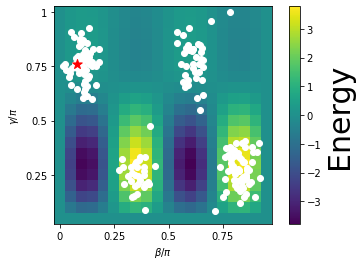

In [10]:
plt.imshow(all_data)
cb = plt.colorbar()
cb.set_label('Energy', fontsize=30)
xys = [h[0] for h in history]
x = [el[0]%(bound)*(samples-1)/(bound) for el in xys]
y = [(bound - (el[1]%bound))*(samples-1)/(bound) for el in xys]
plt.scatter(x, y, c='w')
plt.scatter([result[0][0]%(bound)*(samples-1)/(bound)], [(bound - (result[0][1]%(bound)))*(samples-1)/(bound)], c='red', marker='*', s=100)
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [.25, .5, .75, 1][::-1])

# Annealing

In [11]:
BASELINE_SHOTS

100

In [12]:
shots_per_point = BASELINE_SHOTS
from tqdm import tqdm
annealing_attempts = []
func, history2 = objective(graph)
seed = 1
np.random.seed(seed)
initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
result2 = dual_annealing(
    lambda x: -1*func(x),
    bounds=[(0, max_gamma),
            (0, max_beta)],
    x0=np.array(initial_gamma_beta),
    # One annealing attempt.
    maxiter=NPOPULATION,
    maxfun=one_hour*reprate,
    seed=1)
result2.fun = result2.fun
(result2.x, result2.fun)        

(array([4.2963322 , 0.74540004]), -3.0544084139822267)

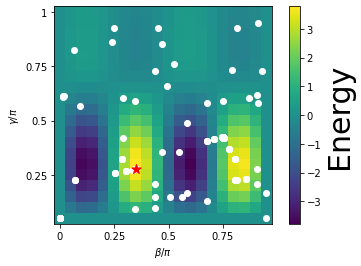

In [13]:
xys2 = [h[0] for h in history2]
x2 = [el[0]%(bound)*(samples-1)/(bound) for el in xys2]
y2 = [(bound - (el[1])%(bound))*(samples-1)/(bound) for el in xys2]
plt.scatter(x2,y2, c='w')
plt.scatter([result2.x[0]%(bound)*(samples-1)/(bound)], [(bound - (result2.x[1]%(bound)))*(samples-1)/(bound)], c='red', marker='*', s=100)
plt.imshow(all_data)
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [.25, .5, .75, 1][::-1])
cb = plt.colorbar()
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
cb.set_label('Energy', fontsize=30)

Text(0, 0.5, 'Fraction of Points')

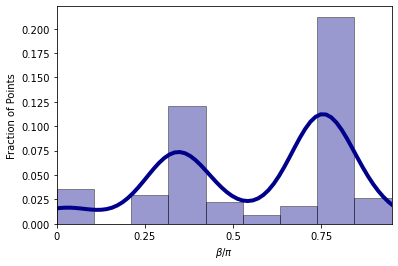

In [14]:
import seaborn as sns
sns.distplot(x2, hist=True, kde=True, 
             bins=int(180/20), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlim(0, 19)
plt.xticks(plt.xticks()[0][0:-1:2], [0, .25, .5, .75,])
#plt.yticks(plt.yticks()[0][0:-1:2], plt.yticks()[1][0:-1:2])
plt.xlabel(r"$\beta/\pi$")
plt.ylabel("Fraction of Points")

Text(0, 0.5, 'Fraction of Points')

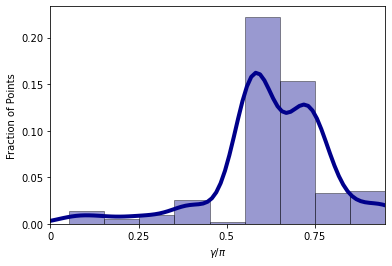

In [15]:
import seaborn as sns
sns.distplot(y2, hist=True, kde=True, 
             bins=int(180/20), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlim(0, 19)
plt.xticks(plt.xticks()[0][0:-1:2], [0, .25, .5, .75,])
#plt.yticks(plt.yticks()[0][0:-1:2], plt.yticks()[1][0:-1:2])
plt.xlabel(r"$\gamma/\pi$")
plt.ylabel("Fraction of Points")